In [2]:
import torch
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#transforma para tensor, normaliza e configura para a cpu ou gpu

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [4]:
trn_ds = MNIST('~/data/FMNIST', transform=img_transform, train=True, download=True)
val_ds = MNIST('~/data/FMNIST', transform=img_transform, train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:03<00:00, 2735708.87it/s]


Extracting /home/zanchet/data/FMNIST/MNIST/raw/train-images-idx3-ubyte.gz to /home/zanchet/data/FMNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 160612.05it/s]


Extracting /home/zanchet/data/FMNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /home/zanchet/data/FMNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:08<00:00, 188521.03it/s]


Extracting /home/zanchet/data/FMNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/zanchet/data/FMNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 5717445.61it/s]

Extracting /home/zanchet/data/FMNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/zanchet/data/FMNIST/MNIST/raw



In [5]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        #realiza o encoding
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            nn.Linear(64, latent_dim))
        #realiza o decoding
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [7]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [9]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5

for epoch in range(num_epochs): 
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)

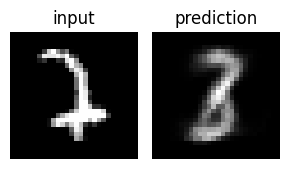

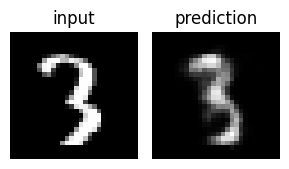

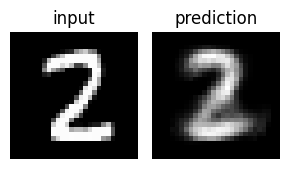

In [13]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()